In [1]:
#Images were retrieved from video lectures of a lecturer in a course with a removed background 
#Then the images were labeled with either unenthusiastic or enthusiastic by an evaluator
#There are 252 images in total

import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
import os

Using TensorFlow backend.
C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\lawre\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\lawre\Anaconda3\envs\te

In [2]:
base_dir = r'C:\Users\lawre\OneDrive\Documents\After_WG\Web-Portfolio\Codes\training_dataset3'
train_dir = os.path.join(base_dir, 'training_dataset')

#Directory with training data of identified unenthusiastic teaching images of the lecturer in the course
train_unenthusiastic_dir = os.path.join(train_dir, 'unenthusiastic')

#Directory with training data of identified enthusiastic teaching images of the lecturer in the course
train_enthusiastic_dir = os.path.join(train_dir, 'enthusiastic')


In [3]:
#Checking names of images
train_unenthusiastic_fnames = os.listdir(train_unenthusiastic_dir)
train_unenthusiastic_fnames.sort()
print(train_unenthusiastic_fnames[:10])

train_enthusiastic_fnames = os.listdir(train_enthusiastic_dir)
print(train_enthusiastic_fnames[:10])

print('total training unenthusiastic images:', len(os.listdir(train_unenthusiastic_dir)))
print('total training enthusiastic images:', len(os.listdir(train_enthusiastic_dir)))

['unenthusiastic1.png', 'unenthusiastic10.png', 'unenthusiastic100.png', 'unenthusiastic101.png', 'unenthusiastic102.png', 'unenthusiastic103.png', 'unenthusiastic104.png', 'unenthusiastic105.png', 'unenthusiastic106.png', 'unenthusiastic107.png']
['enthusiastic1.png', 'enthusiastic10.png', 'enthusiastic100.png', 'enthusiastic101.png', 'enthusiastic102.png', 'enthusiastic103.png', 'enthusiastic104.png', 'enthusiastic105.png', 'enthusiastic106.png', 'enthusiastic107.png']
total training unenthusiastic images: 118
total training enthusiastic images: 134


In [4]:
#Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

#Index for iterating over images
pic_index = 0

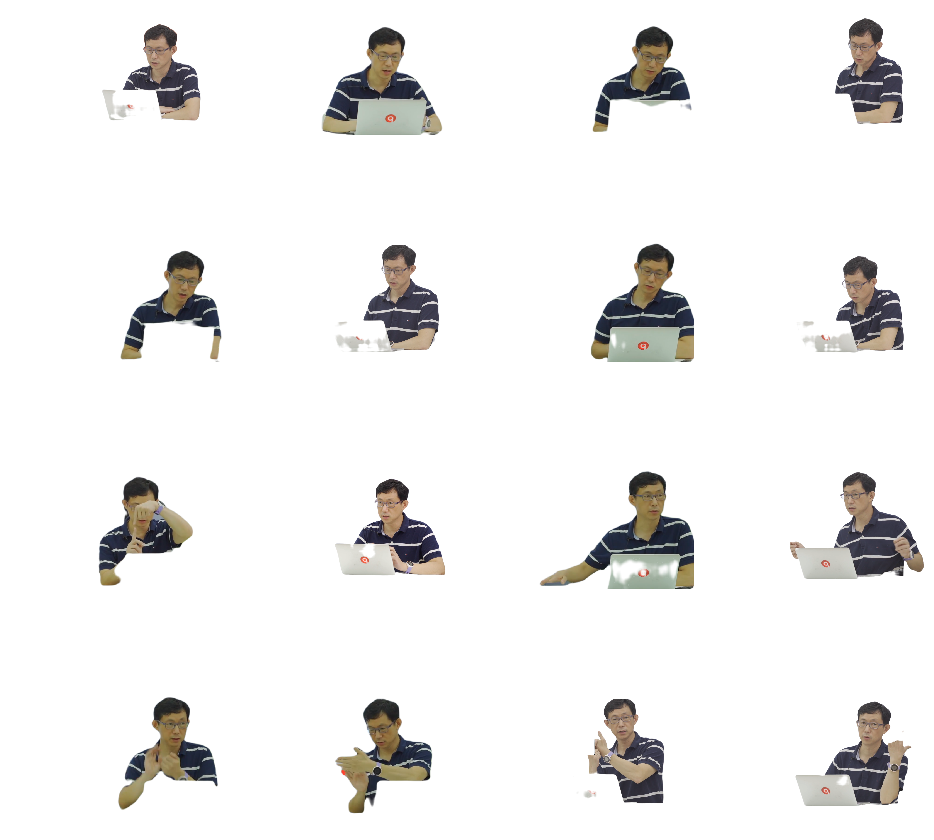

In [5]:
#Seting up matplotlib fig, and sizing it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_unenthusiastic_pix = [os.path.join(train_unenthusiastic_dir, fname) 
                for fname in train_unenthusiastic_fnames[pic_index-8:pic_index]]
next_enthusiastic_pix = [os.path.join(train_enthusiastic_dir, fname) 
                for fname in train_enthusiastic_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_unenthusiastic_pix+next_enthusiastic_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

#Now let's set some hyperparameters for the CNN model which will be trained to be the evaluator!

#Input feature map is 333X333x3: 333X333 for the image pixels, and 3 for
#the three color channels: R, G, and B
img_input = layers.Input(shape=(333, 333, 3))

#First convolution extracts 16 filters that are 3x3
#Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

#Second convolution extracts 32 filters that are 3x3
#Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Third convolution extracts 64 filters that are 3x3
#Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

#Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

#Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

#Create model:
#input = input feature map
#output = input feature map + stacked convolution/maxpooling layers + fully 
#connected layer + sigmoid output layer
model = Model(img_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 333, 333, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 331, 331, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 165, 165, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 163, 163, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 81, 81, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 79, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 39, 64)        0         
__________

In [7]:
#Define the loss function, the optimizer and the metrics
model.compile(loss='binary_crossentropy',    
              optimizer=RMSprop(lr=0.0001),     
              metrics=['acc'])

#Plotting the model
from tensorflow.keras.utils import plot_model
import pydot_ng as pydot

plot_model(model, to_file='model_SOU_removed-background.png')

In [8]:
#Let's do data preprocessing!
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

#Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(333, 333),  # All images will be resized to 333X333
        classes= ['unenthusiastic', 'enthusiastic'],    #defult: 0为前者, 1会后者
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

train_labels = train_generator.classes 
train_labels

Found 252 images belonging to 2 classes.


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
#Now train the CNN model!
history = model.fit_generator(
      train_generator,  
      epochs=9    
      )

Epoch 1/9
16/16 [==============================] - 44s 3s/step - loss: 0.6648 - acc: 0.5704
Epoch 2/9
16/16 [==============================] - 41s 3s/step - loss: 0.5983 - acc: 0.7058
Epoch 3/9
16/16 [==============================] - 41s 3s/step - loss: 0.5552 - acc: 0.7903
Epoch 4/9
16/16 [==============================] - 41s 3s/step - loss: 0.5196 - acc: 0.7928
Epoch 5/9
16/16 [==============================] - 40s 2s/step - loss: 0.4869 - acc: 0.7994
Epoch 6/9
16/16 [==============================] - 40s 3s/step - loss: 0.4633 - acc: 0.8072
Epoch 7/9
16/16 [==============================] - 40s 2s/step - loss: 0.4340 - acc: 0.8165
Epoch 8/9
16/16 [==============================] - 40s 3s/step - loss: 0.4168 - acc: 0.8360
Epoch 9/9
16/16 [==============================] - 42s 3s/step - loss: 0.3940 - acc: 0.8463


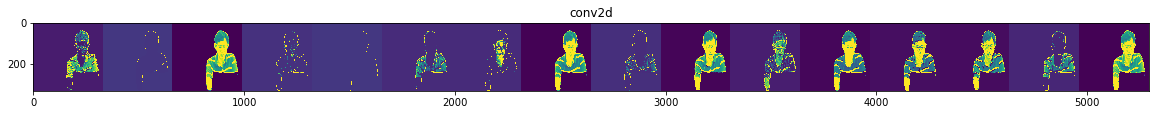

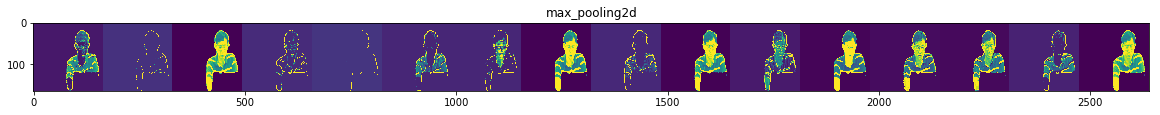

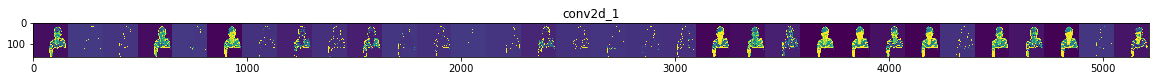

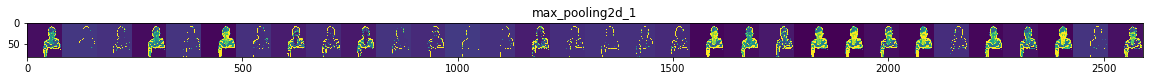

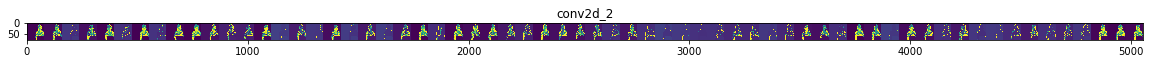

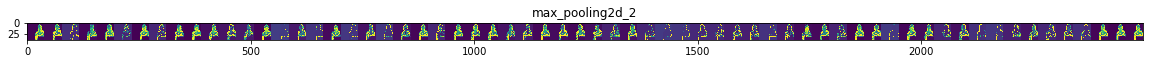

In [10]:
#Visualing feature map!

import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#Let's define a new Model that will take an image as input, and will output
#intermediate representations for all layers in the previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

#Let's prepare a random input image of a unenthusiastic or ununenthusiastic from the training set.
unenthusiastic_img_files = [os.path.join(train_unenthusiastic_dir, f) for f in train_unenthusiastic_fnames]
enthusiastic_img_files = [os.path.join(train_enthusiastic_dir, f) for f in train_enthusiastic_fnames]
img_path = random.choice(unenthusiastic_img_files + unenthusiastic_img_files)

img = load_img(img_path, target_size=(333, 333))  #this is a PIL image
x = img_to_array(img)  #Numpy array with shape (333, 333, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 333, 333, 3)

# Rescale by 1/255
x /= 255

#Let's run our image through our network, thus obtaining all
#intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

#These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]    #NOTE: it is model.layers[1:] instead of model.layers!

#Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    #Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]    #number of features in feature map
    #The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    #We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      #Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      #We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    #Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training loss')

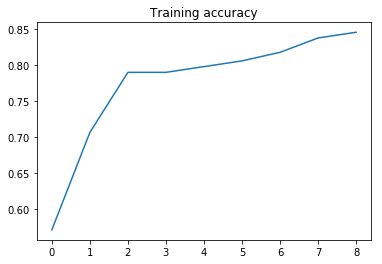

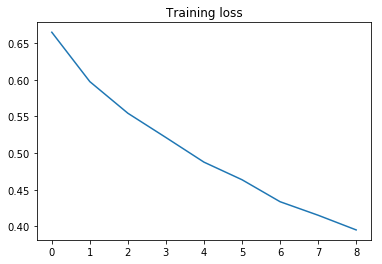

In [11]:
#Retrieve a list of accuracy results on training and validation data
#sets for each training epoch
acc = history.history['acc']

#Retrieve a list of list results on training and validation data
#sets for each training epoch
loss = history.history['loss']

#Get number of epochs
epochs = range(len(acc))

#Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.title('Training accuracy')

plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.title('Training loss')

In [12]:
#All right! Now let's start applying LIME to the CNN model!

#First, Listing the probabilities of being classified as 'enthusiastic' among unenthusiastic images
import skimage

unen_img = []
for i in range(118):
    img_path = os.path.join(train_unenthusiastic_dir, 'unenthusiastic'+str( (i+1))+'.png')
    img = load_img(img_path, target_size=(333, 333))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    x /= 255
    unen_img.append(x)

len(unen_img)

118

In [13]:
prob_of_en_on_unenIMG = []
for i in range(118):
    a = model.predict(unen_img[i])
    a = a.flatten()
    a = a.tolist()
    prob_of_en_on_unenIMG.append(a)

prob_of_en_on_unenIMG
#Get predicted class probabilities (binary classification) 
#the dense layer consisting of one unit with an activation function of the sigmoid. 
#sigmoid function outputs a value in the range [0,1] which corresponds to 
#the probability of the given sample belonging to a positive class (i.e. class 1).
#Recall: in ImageDataGenerator, classes= ['x', 'y']
#where the defult is: 0 label as negative class as 'x', vice versa!

#Note: the 118 images below belong to 'unenthusiastic'(labeled by the evaluator), 
#therefore the probabilitie should be close to 0.
#There are some misclassifications (i.e. probabilities are heigher than 0.5)
#Since the model has over 95% accuracy rate, those misclassifications are just a few!

[[0.508765697479248],
 [0.1681443303823471],
 [0.4154244065284729],
 [0.13247911632061005],
 [0.11865886300802231],
 [0.316439151763916],
 [0.45561161637306213],
 [0.18740421533584595],
 [0.12077498435974121],
 [0.138363778591156],
 [0.3950366973876953],
 [0.2863788604736328],
 [0.6565147638320923],
 [0.6647551655769348],
 [0.3201712369918823],
 [0.3526408076286316],
 [0.15746895968914032],
 [0.2593878209590912],
 [0.4218769371509552],
 [0.3330945670604706],
 [0.24007515609264374],
 [0.2628270983695984],
 [0.15197527408599854],
 [0.12945963442325592],
 [0.14490148425102234],
 [0.2774146497249603],
 [0.13055554032325745],
 [0.6222655177116394],
 [0.52012699842453],
 [0.5149317383766174],
 [0.2140807807445526],
 [0.1909019500017166],
 [0.462215781211853],
 [0.31606635451316833],
 [0.15426082909107208],
 [0.6212257742881775],
 [0.4810735285282135],
 [0.4121113717556],
 [0.3727998435497284],
 [0.1874506175518036],
 [0.3120330274105072],
 [0.15266066789627075],
 [0.2819204330444336],
 [0.28

In [14]:
#Second, Listing the probabilities of being classified as 'enthusiastic' among enthusiastic images
#Note: the 134 images below belong to 'enthusiastic' (labeled by the evaluator), 
#therefore the probabilitie should be close to 1.

en_img = []
for i in range(134):
    img_path = os.path.join(train_enthusiastic_dir, 'enthusiastic'+str( (i+1))+'.png')
    img = load_img(img_path, target_size=(333, 333))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    x /= 255
    en_img.append(x)

len(en_img)

134

In [15]:
prob_of_en_on_enIMG = []
for i in range(134):
    b = model.predict(en_img[i])
    b = b.flatten()
    b = b.tolist()
    prob_of_en_on_enIMG.append(b)

prob_of_en_on_enIMG

[[0.9233344793319702],
 [0.4339468777179718],
 [0.4318627715110779],
 [0.48954200744628906],
 [0.6143258810043335],
 [0.5033633708953857],
 [0.8803198337554932],
 [0.8822089433670044],
 [0.8830828666687012],
 [0.8587085604667664],
 [0.33894631266593933],
 [0.900912880897522],
 [0.3837150037288666],
 [0.8789680004119873],
 [0.8809937834739685],
 [0.8971983194351196],
 [0.4042064845561981],
 [0.9459397792816162],
 [0.9015966057777405],
 [0.8659908175468445],
 [0.879423975944519],
 [0.8666692972183228],
 [0.8781975507736206],
 [0.6659559607505798],
 [0.8592767119407654],
 [0.7228280305862427],
 [0.7679007649421692],
 [0.850260853767395],
 [0.8389406800270081],
 [0.8016459941864014],
 [0.8392535448074341],
 [0.9445908069610596],
 [0.83033287525177],
 [0.8413956761360168],
 [0.5041077733039856],
 [0.7832310199737549],
 [0.44859781861305237],
 [0.688390851020813],
 [0.9495181441307068],
 [0.8867383003234863],
 [0.8490767478942871],
 [0.9569827318191528],
 [0.9534584879875183],
 [0.9748865365

In [16]:
#https://stackoverflow.com/questions/34990652/why-do-we-need-np-squeeze
#Use numpy.squeeze() function to remove single-dimensional entries (length = 1) from the shape of an array.
#e.g. (1, 3, 3) => (3, 3); (1, 3, 1) = > (3,)
unen_img_squeeze = []

for i in range(118):
    c = np.squeeze(unen_img[i], axis=0)
    unen_img_squeeze.append(c)

In [17]:
en_img_squeeze = []

for i in range(134):
    d = np.squeeze(en_img[i], axis=0)
    en_img_squeeze.append(d)

In [18]:
import skimage.segmentation
import skimage.io
import copy
import sklearn
from sklearn.linear_model import LinearRegression

#Create function to apply perturbations to images
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

num_perturb = 300    #The more, the merrier. I just want to save time here.
num_top_features = 5
predictions_134 = {}
LIME_results_134 = {}
for i in range(134):
    superpixels = skimage.segmentation.quickshift(en_img_squeeze[i], kernel_size=2, max_dist=100, ratio=0.5)    #random each time
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels)) 
    predictions_134[i] = []     
    for pert in perturbations:    
        perturbed_img = perturb_image(en_img_squeeze[i],pert,superpixels)
        pred = model.predict(perturbed_img[np.newaxis,:,:,:])   
        predictions_134[i].append(pred)
    predictions_134[i] = np.array(predictions_134[i]) 
    predictions_134[i] = np.squeeze(predictions_134[i], axis=1)
    original_image = np.ones(num_superpixels)[np.newaxis,:] 
    distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()
    kernel_width = 0.25
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) 
    simpler_model = LinearRegression().fit(X=perturbations, y=predictions_134[i], sample_weight=weights)  
    coeff = simpler_model.coef_
    top_features = np.argsort(coeff)[0, -num_top_features:]
    def perturb_image2(mask, segments): 
        active_pixels = top_features
        for active in active_pixels:
            mask[segments == active] = 1 
        return mask
    mask =  np.zeros(superpixels.shape)
    C = perturb_image2(mask, superpixels)
    D = np.int64(C)
    LIME_results_134[i] = skimage.segmentation.mark_boundaries(en_img_squeeze[i], D)

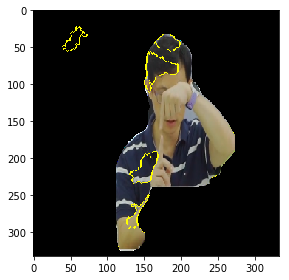

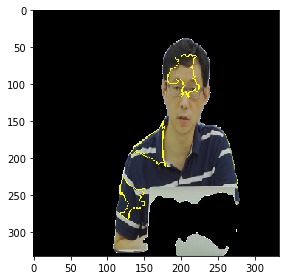

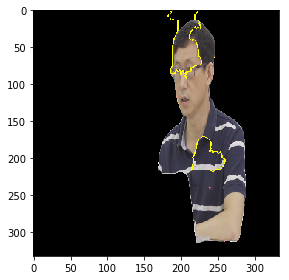

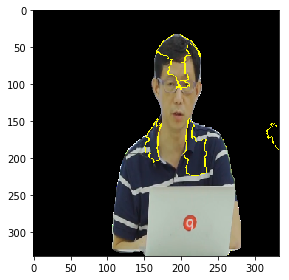

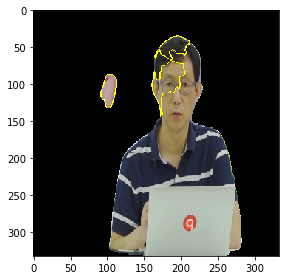

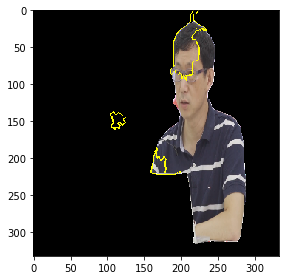

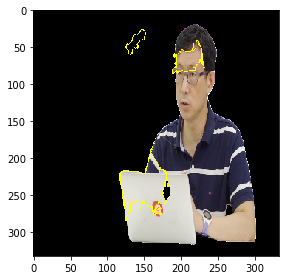

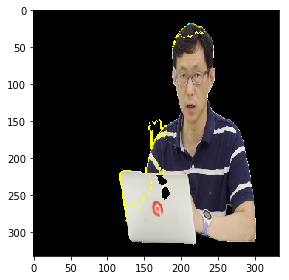

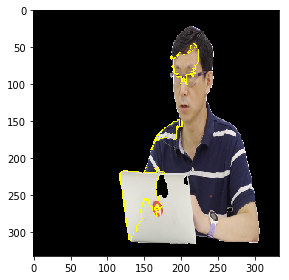

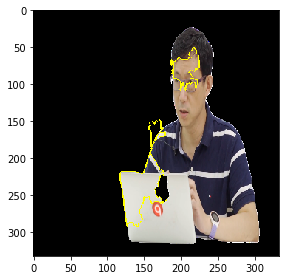

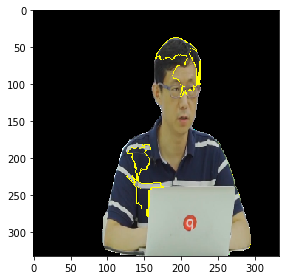

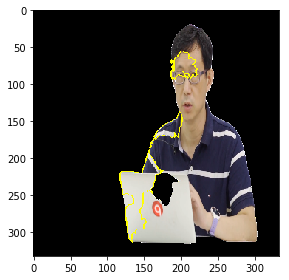

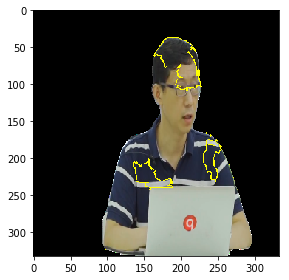

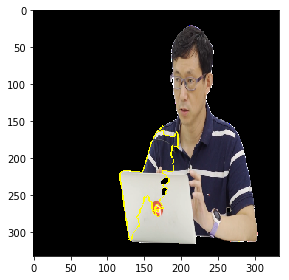

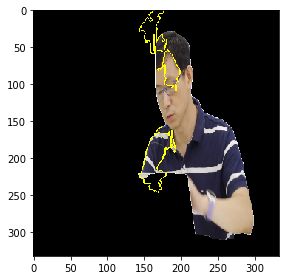

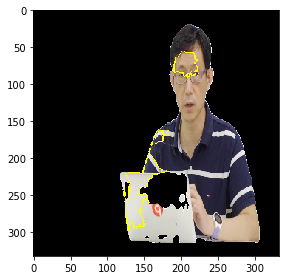

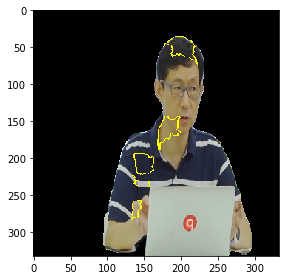

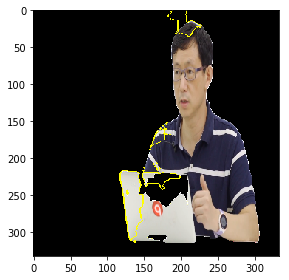

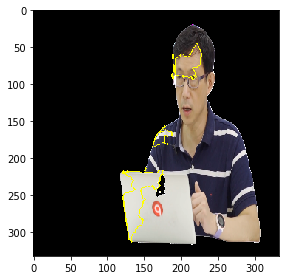

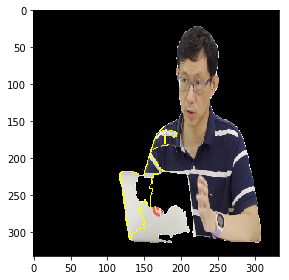

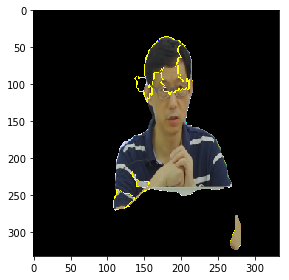

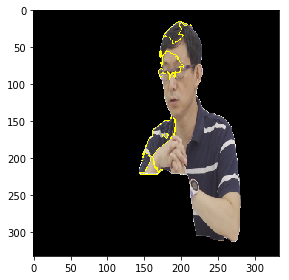

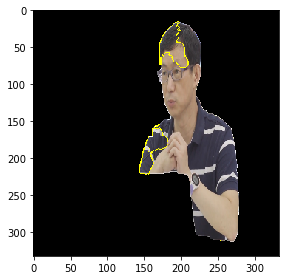

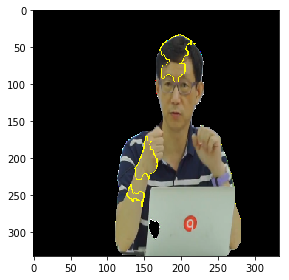

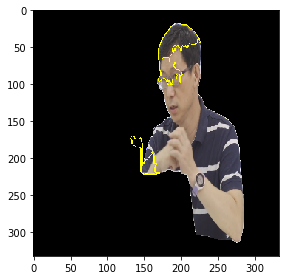

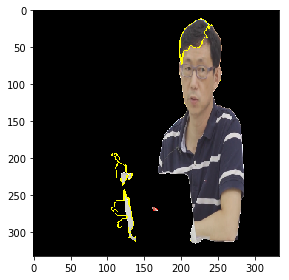

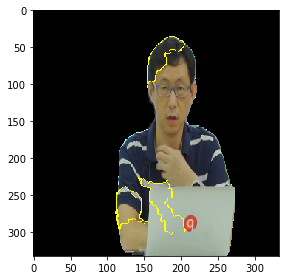

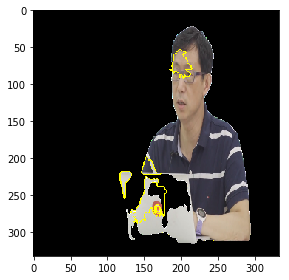

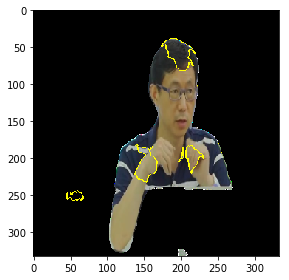

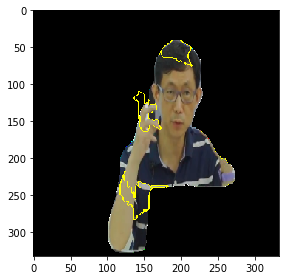

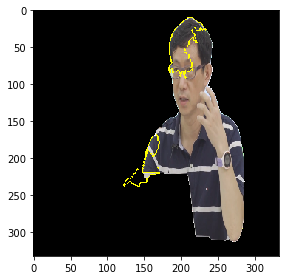

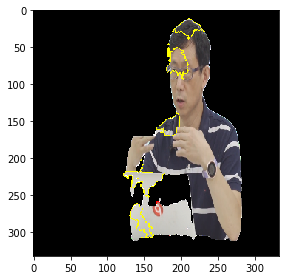

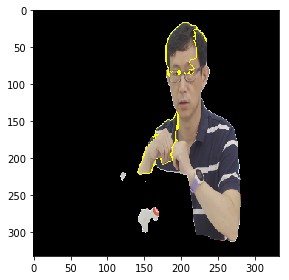

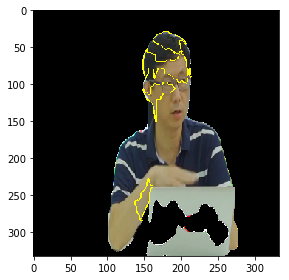

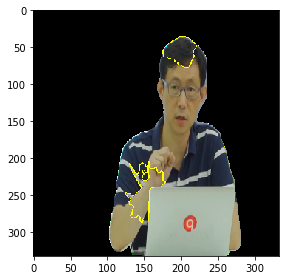

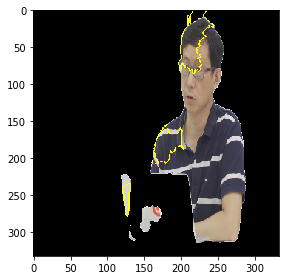

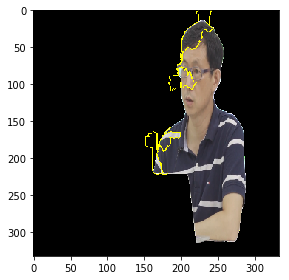

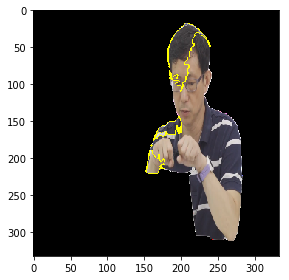

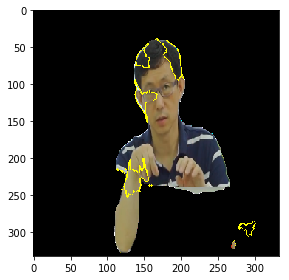

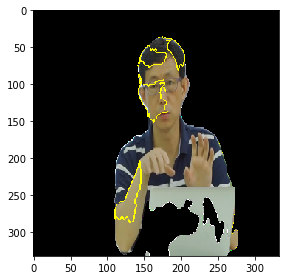

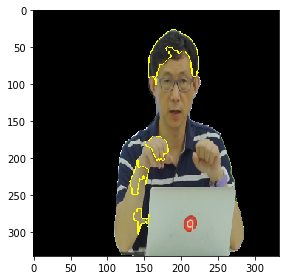

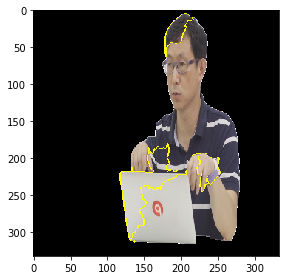

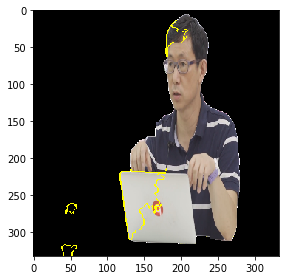

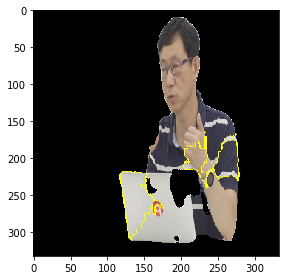

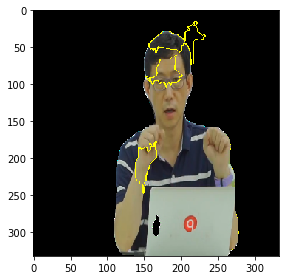

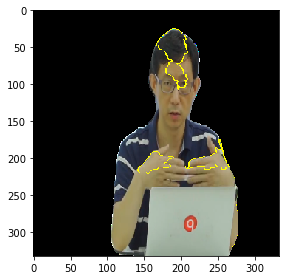

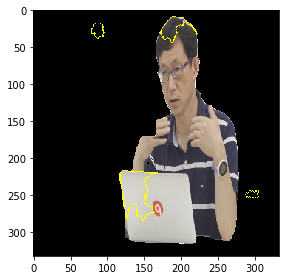

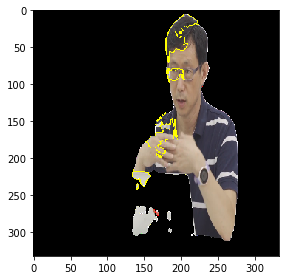

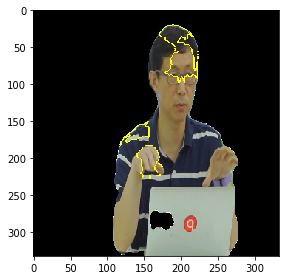

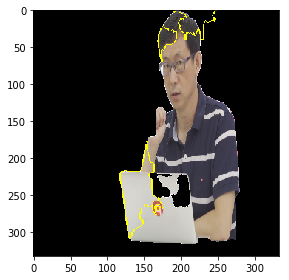

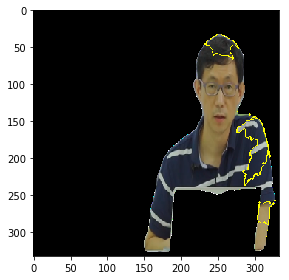

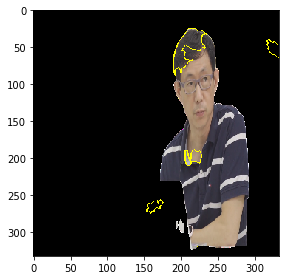

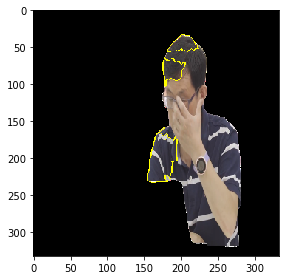

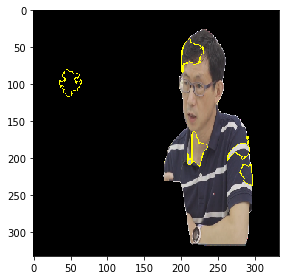

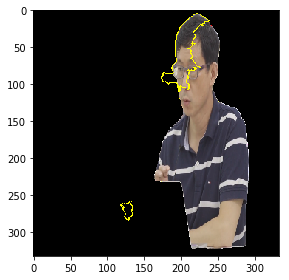

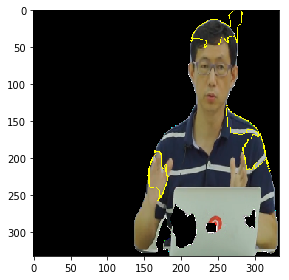

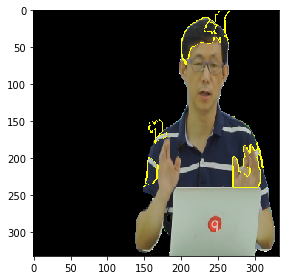

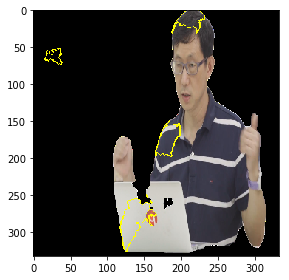

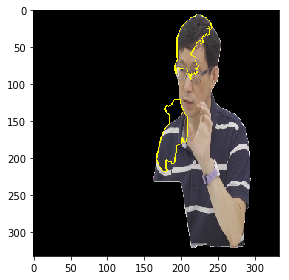

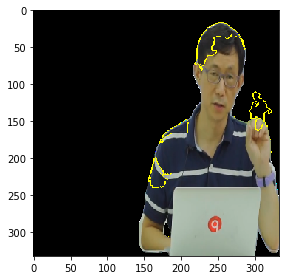

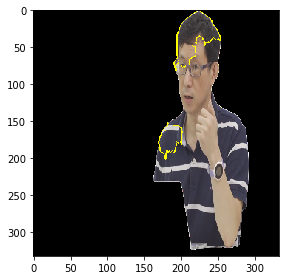

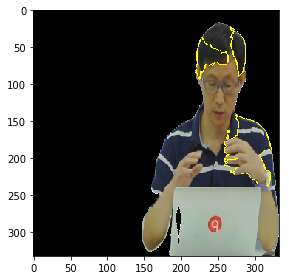

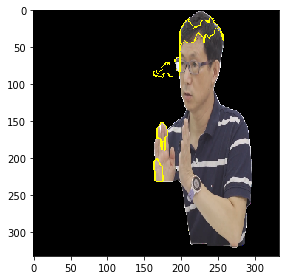

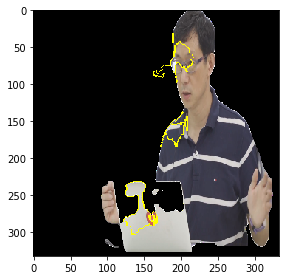

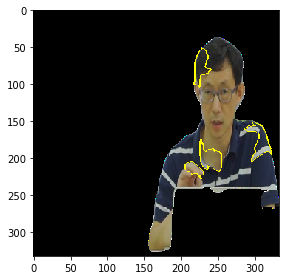

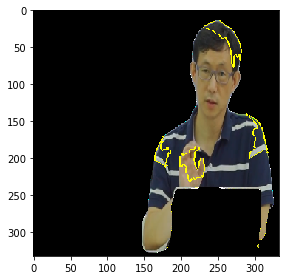

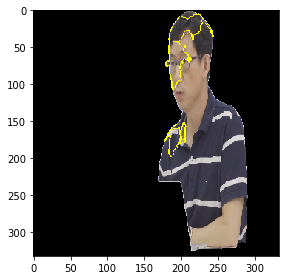

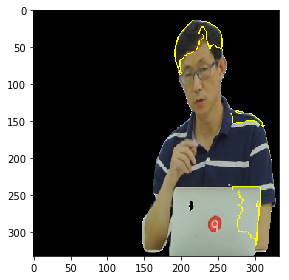

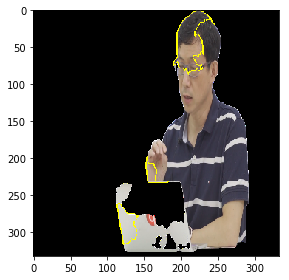

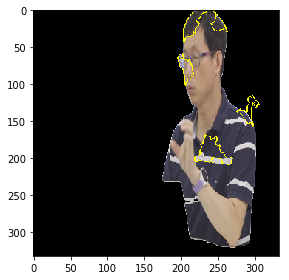

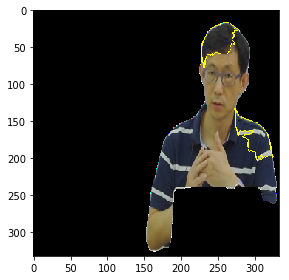

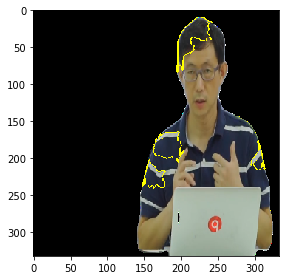

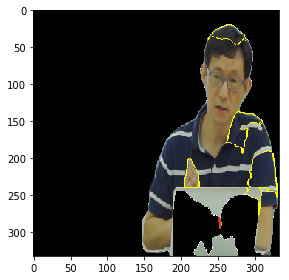

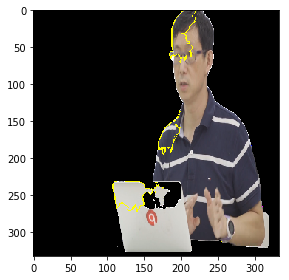

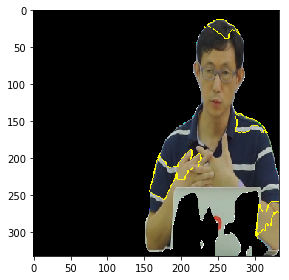

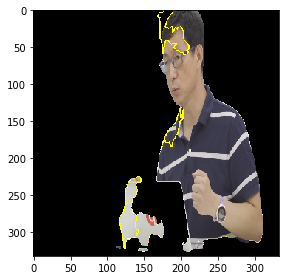

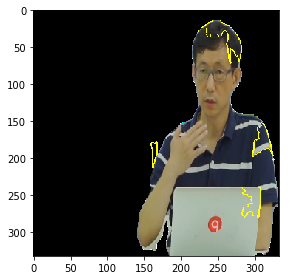

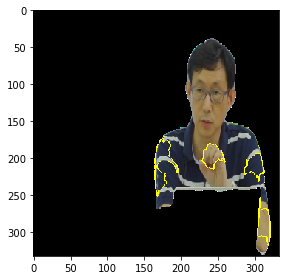

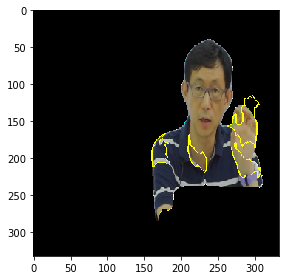

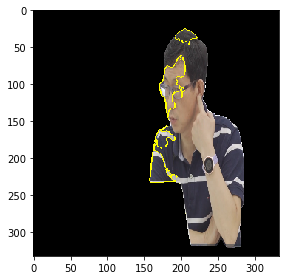

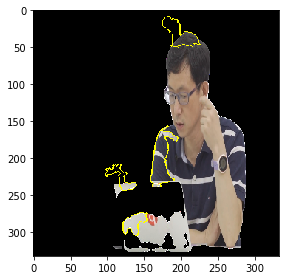

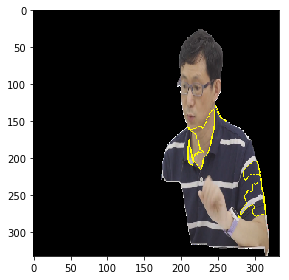

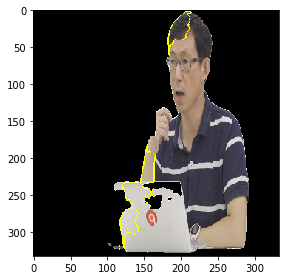

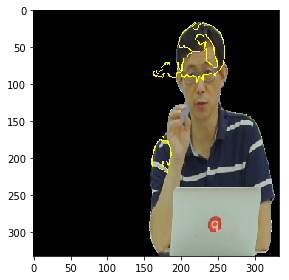

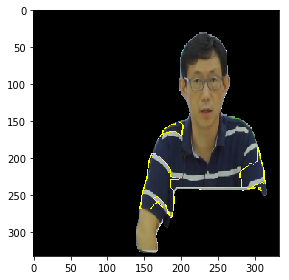

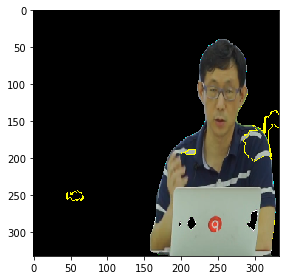

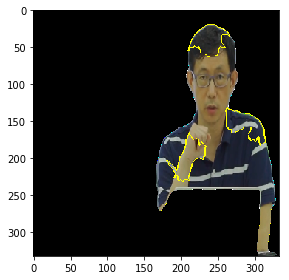

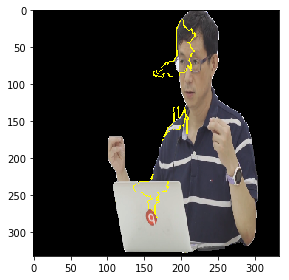

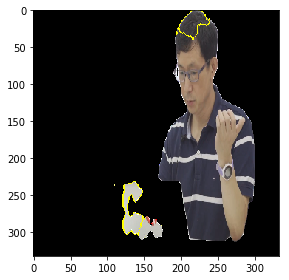

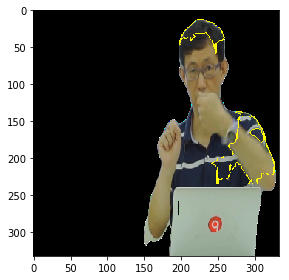

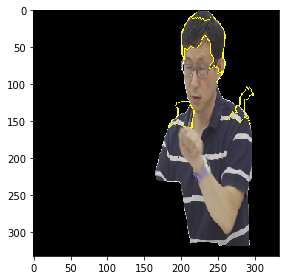

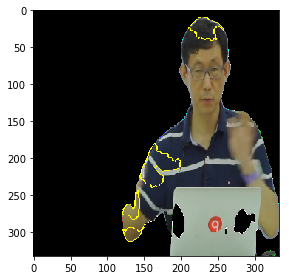

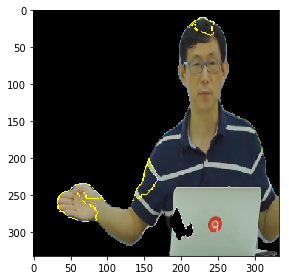

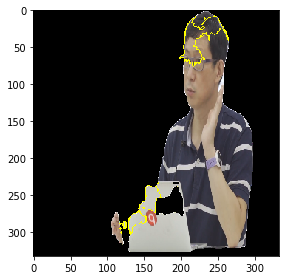

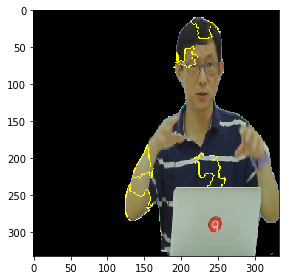

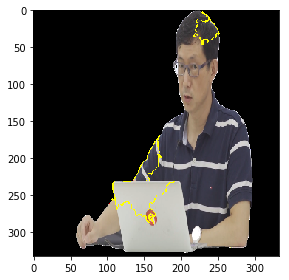

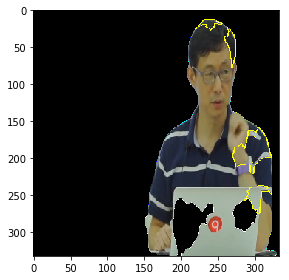

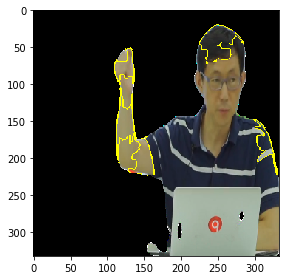

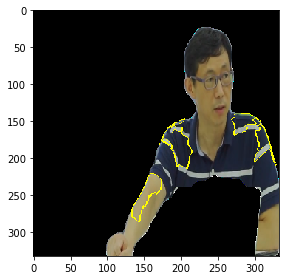

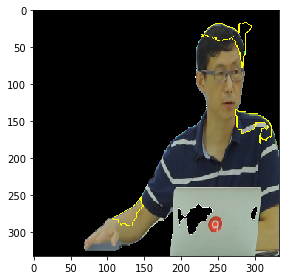

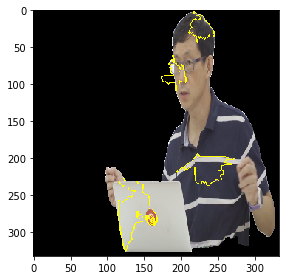

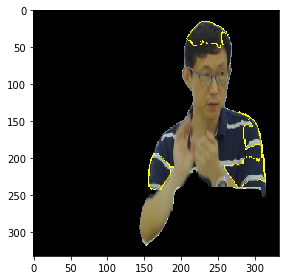

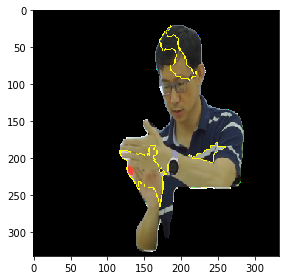

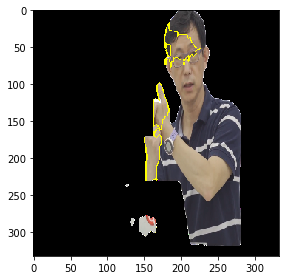

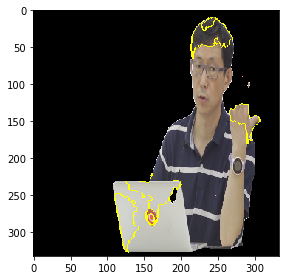

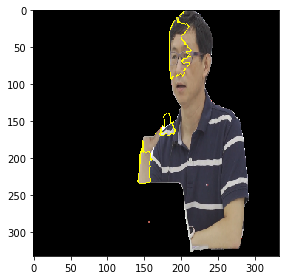

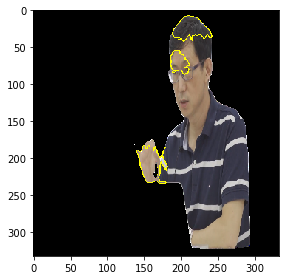

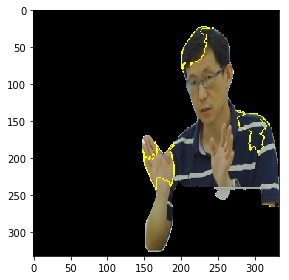

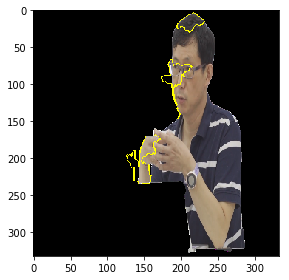

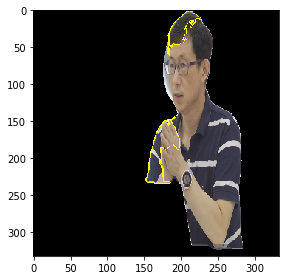

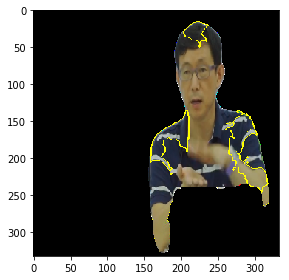

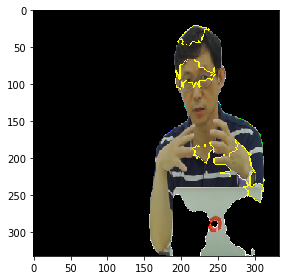

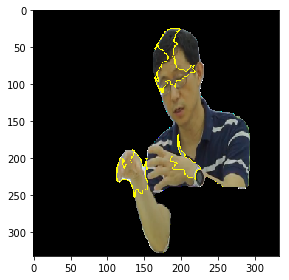

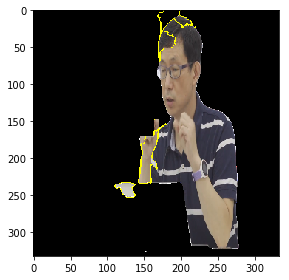

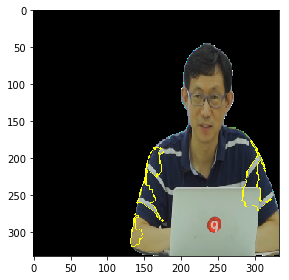

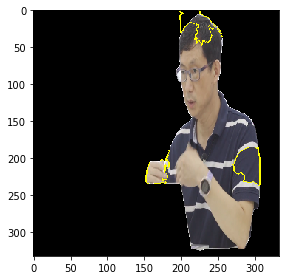

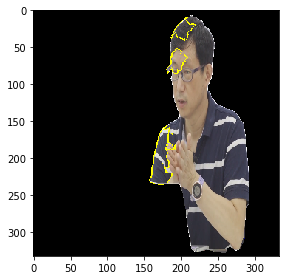

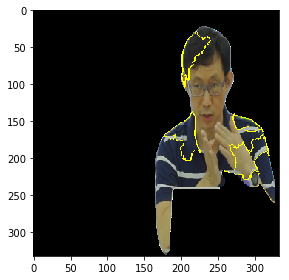

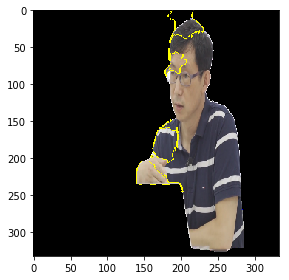

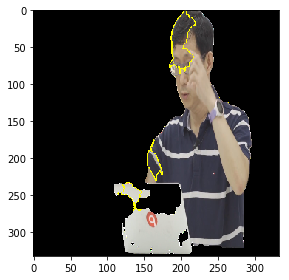

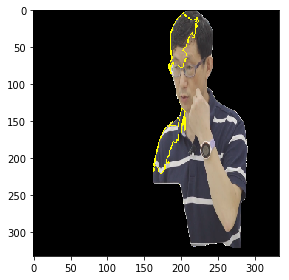

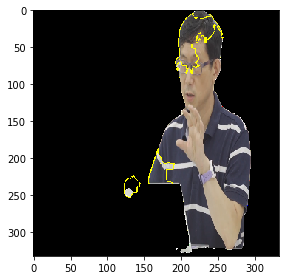

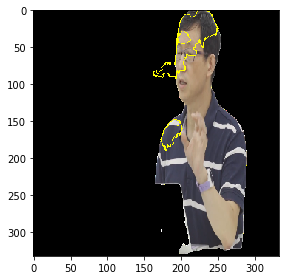

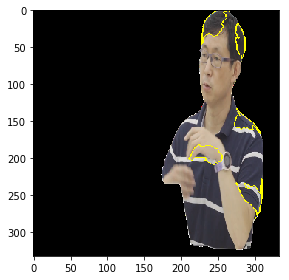

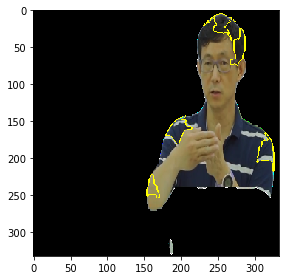

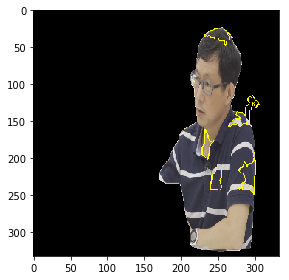

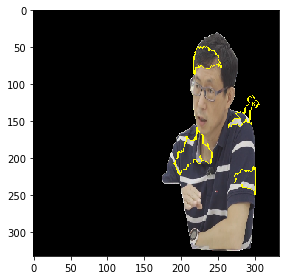

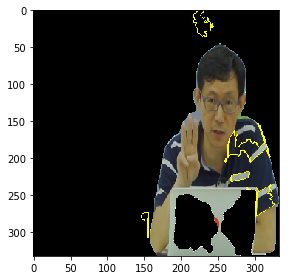

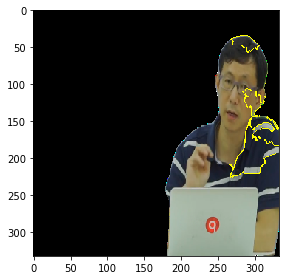

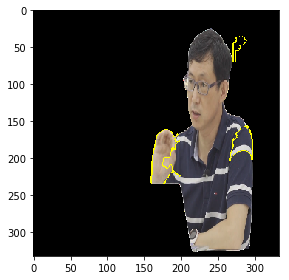

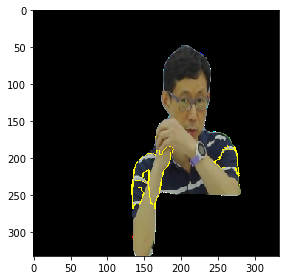

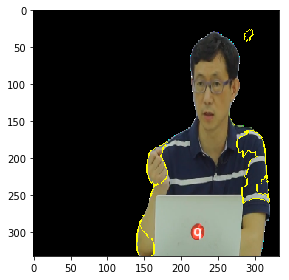

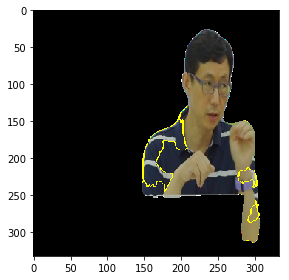

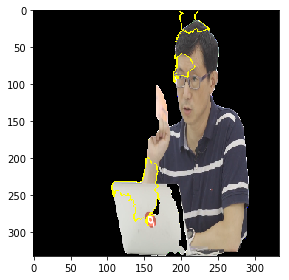

In [19]:
from matplotlib.pyplot import show    #the show() function in matplotlib is used to display all figures

images = []
for i in range(134):
    images.append(LIME_results_134[i])

for i in images:
    skimage.io.imshow(i)
    show()
    time.sleep(0.01)